## A pipeline for processing and analyzing multiplexed images

#### Developed for related project: A spatial single-cell type map of adult human spermatogenesis (Cecilia Bergström's group)

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import io
import sklearn
import time

# stardist
from stardist.models import StarDist2D, Config2D
from stardist.plot import render_label
from csbdeep.utils import normalize

from skimage import io, filters, measure, segmentation, color, util, exposure, morphology
from skimage.filters import threshold_otsu

from tiler import Tiler, Merger 

import warnings
warnings.filterwarnings('ignore')

%run ../src/functions.py

2024-06-04 03:44:11.591206: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/miniconda3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.2.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


>>> GPU activated? 0


### Define input path, image of interest and other parameters

In [2]:
# set distance to be used to grow the cell after segmentation
dist = 3

# set the segmentation method
seg_method = 'stardist' # choose between 'cellpose' of 'stardist'

# set startdist parameters
nms_thresh = 0.8
prob_thresh = 0.7
 
# pre-process OPAL channels? True or False
preprocessOPAL = False 

# apply size filter to segmented objetcts
filterByArea = True
min_size = np.array([0,100,100,100,100,100,100,0]) # define value per channel
max_size = np.array([100000,100000,100000,100000,100000,100000,100000,100000]) # define value per channel

# define levels of Ostu threshold
#multi_otsu = False
multi_otsu_levels = np.array([0,2,2,2,2,2,2,0])

# set order of the channels
cols = ['DAPI','OPAL480','OPAL520','OPAL570','OPAL620','OPAL690','OPAL780','Autofluorescence']

# save output image files
save_img = False

# split image before segmentation
split = False

## Running the pipeline for reference image

### Load image of interest and define channel to be segmented

100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


Nuclei and AF channel: loaded  (4795, 4792)
Pre-processing cell image: finished


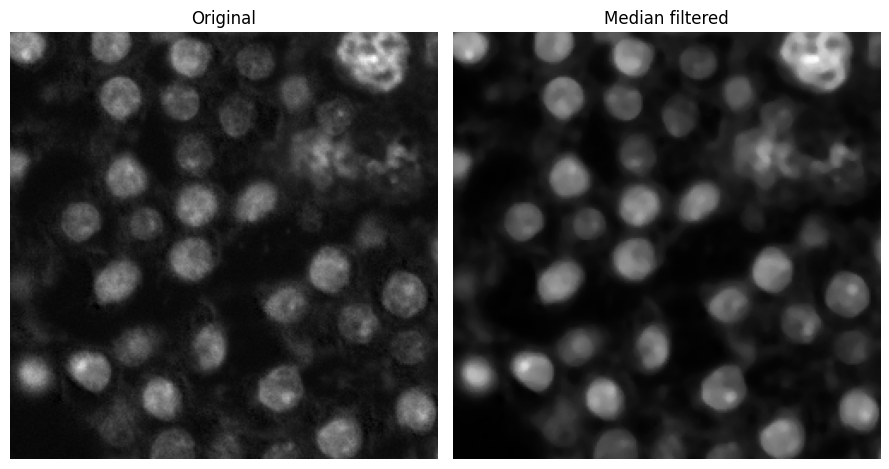

In [3]:
# Define paths
path = '../data/' # update input path!
ref_image = '20460292_2A_13070-41475_component_data.tif'
ilastik_mask = '20460292_2A_13070-41475_component_data_520_Simple Segmentation.tiff'

outpath = path + '/output_nms-' + str(nms_thresh) + '_prob-' + str(prob_thresh)
if not os.path.exists(outpath):
    os.makedirs(outpath)

# Read reference image

ref_img = io.imread(os.path.join(path, ref_image))

# Select channel to be segmented
original = ref_img[0,:,:] + ref_img[7,:,:]
print("Nuclei and AF channel: loaded ", original.shape)

# Apply pre-processing to the AF channel
filtered = preprocess(original)
print("Pre-processing cell image: finished")

# Show pre-processing
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(9, 5),
    sharex=True,
    sharey=True,
)

axes[0].imshow(exposure.rescale_intensity(original[1000:1250, 1000:1250]), cmap="gray")
axes[0].set_title("Original")

axes[1].imshow(exposure.rescale_intensity(filtered[1000:1250, 1000:1250]), cmap="gray")
axes[1].set_title("Median filtered")

for a in axes:
    a.axis("off")
fig.tight_layout()
plt.show()

### Run cell segmentation and save both label and binary masks

segmenting...
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
1/1 [==============================] - 9s 9s/step


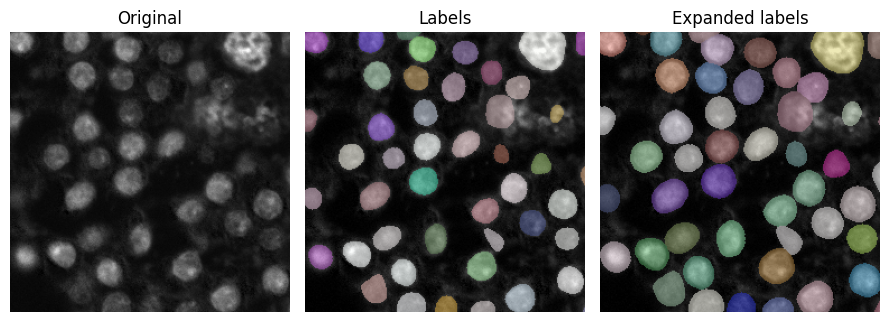

In [4]:
# if split option is set True, then split in tiles
if split:
    image16 = filtered.astype('uint16')
    full_image = np.reshape(image16, [1, filtered.shape[0], filtered.shape[1]])

    blockSize = 2000
    # Setup tiling parameters
    tiler = Tiler(data_shape=full_image.shape,tile_shape=(1, blockSize, blockSize),overlap=0,channel_dimension=0)
    merger = Merger(tiler)

    countLabels = 0
    
    # Process the image tile-by-tile
    for tile_id, tile in tiler(full_image):
        print(f"processing tile {tile_id}...")
        # run inference
        
        tile_new = tile[0,:,:]
        
        labels = segment_with_stardist(normalize(tile_new),[nms_thresh, prob_thresh])    
        maxLabelTile = np.amax(labels) # get max label of the current mask
        labels = np.where(labels > 0, labels+countLabels, labels) # sum countLabels to the current mask
        countLabels = countLabels + maxLabelTile # sum current max label to countLabels

        tile_res = np.reshape(labels, [1, labels.shape[0], labels.shape[1]])
        merger.add(tile_id, tile_res)
        
    # Merge the image
    merged_image = merger.merge(unpad=True)
    io.imsave(outpath + '/_testDAPI_segmented_merged.tif',merged_image.astype('uint16'))

    labels = stitchSegmentedTiles(merged_image, blockSize)
    labels = labels[:,:,0]
    io.imsave(outpath + '/_testDAPI_segmented_merged_labeled.tif',labels.astype('uint16'))
else:
    print('segmenting...')
    labels = segment_with_stardist(normalize(filtered),[nms_thresh, prob_thresh])
    
# Get binary mask
binary_mask = labels.copy()
binary_mask[binary_mask > 0] = 1

io.imsave(outpath + '/_cells_labels.tif',labels)
io.imsave(outpath + '/_cells_binary.tif',util.img_as_ubyte(binary_mask*255))

### Expand labels to incorporate cells' neighborhoods
expanded_labels = segmentation.expand_labels(labels, distance=dist)
io.imsave(outpath + '/_cells_labels_expanded.tif',expanded_labels)

# Show the segmentations.
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(9, 5),
    sharex=True,
    sharey=True,
)

axes[0].imshow(exposure.rescale_intensity(original[1000:1250, 1000:1250]), cmap="gray")
axes[0].set_title("Original")

axes[1].imshow(render_label(labels, img=original)[1000:1250, 1000:1250])
axes[1].set_title("Labels")

axes[2].imshow(render_label(expanded_labels, img=original)[1000:1250, 1000:1250])
axes[2].set_title("Expanded labels")

for a in axes:
    a.axis("off")
fig.tight_layout()
plt.show()

## Retrieve quantitative measures
### 1) Get mean fluorescence intensity for each nuclei and for each channel. Save results on a dataframe


In [5]:
properties = ['label', 'intensity_mean']

mean_intens = get_avg_intensity(ref_img, expanded_labels, cols, properties)

# add file id
ref_series = pd.Series(ref_image)
ref_series = ref_series.repeat(mean_intens.shape[0])
mean_intens['file'] = ref_series.values
mean_intens.reset_index(['label'],inplace=True)
mean_intens.set_index(['file','label'],inplace=True)
# save as csv
mean_intens.to_csv(os.path.join(outpath, 'mean_intensity.csv'), sep=';')

# exclude DAPI, AF and OPAL520 from dataframe
mean_intens_OPAL = mean_intens.drop(columns=['DAPI', 'Autofluorescence', 'OPAL520'], axis=1)

# rearrange cols
cols_sorted = ['OPAL480', 'OPAL620', 'OPAL690', 'OPAL780', 'OPAL570']
mean_intens_OPAL = mean_intens_OPAL[cols_sorted]
mean_intens_OPAL

OPAL480    OPAL620  \
file                                       label                         
20460292_2A_13070-41475_component_data.tif 1      21.938210   4.725718   
                                           2      11.785081   4.023408   
                                           3      30.080065   5.224208   
                                           4      38.137032   2.713200   
                                           5      20.384022   4.547355   
...                                                     ...        ...   
                                           5946    2.676630  10.001680   
                                           5947    8.392918   3.486778   
                                           5948   25.335844   1.727555   
                                           5949   11.187607   3.830871   
                                           5950    8.005949   3.629628   

                                                    OPAL690   OPAL780  \
file                                       label                        
20460292_2A_13070-41475_component_data.tif 1       3.049762  0.955775   
                                           2       6.259189  9.504576   
                                           3       2.171147  1.427804   
                                           4      11.187169  0.183400   
                                           5       1.843506  1.155307   
...                                                     ...       ...   
                                           5946    0.420918  0.298076   
                                           5947    1.577119  0.204589   
                                           5948   15.460492  0.174486   
                                           5949    2.937840  9.588073   
                                           5950    2.259073  0.961221   

                                                    OPAL570  
file                                       label             
20460292_2A_13070-41475_component_data.tif 1       1.075265  
                                           2       1.318890  
                                           3       0.881668  
                                           4       1.325490  
                                           5       0.928302  
...                                                     ...  
                                           5946   48.244774  
                                           5947    1.029258  
                                           5948    0.972595  
                                           5949    1.487712  
                                           5950    3.957175  

[5950 rows x 5 columns]

### 2) Get mean fluorescence intensity for each nuclei and for each channel, given the thresholded masks, and save results on a dataframe

In [6]:
# get enlarged-labels image as a binary mask
expanded_binary_mask = expanded_labels.copy()
expanded_binary_mask[expanded_binary_mask > 0] = 1

# OPAL quantification
ilastik_mask = path + ilastik_mask
print(ilastik_mask)
mean_intens_thres, thresholded, intens_masks = opal_quantification(ref_img, expanded_labels, expanded_binary_mask, ilastik_mask, cols, filterByArea, min_size, max_size, preprocessOPAL, multi_otsu_levels)

# filter ['DAPI', 'Autofluorescence'] out
mean_intens_thres = filter_columns(['DAPI', 'Autofluorescence'], mean_intens_thres)

# add file id
mean_intens_thres['file'] = ref_series.values
mean_intens_thres.reset_index(['label'],inplace=True)
mean_intens_thres.set_index(['file','label'],inplace=True)
mean_intens_thres.to_csv(os.path.join(outpath, 'mean_intensity_threshold.csv'), sep=';')

mean_intens_thres

/Users/giselemiranda/ToOneDrive/BIIF/projects/Feria_Cecilia/new/input5/20460292/20460292_2A_13070-41475_component_data_520_Simple Segmentation.tiff
channel: DAPI
channel: OPAL480
channel: OPAL520
channel: OPAL570
channel: OPAL620
channel: OPAL690
channel: OPAL780
channel: Autofluorescence


OPAL480   OPAL520  \
file                                       label                        
20460292_2A_13070-41475_component_data.tif 1      30.427882  0.000000   
                                           2       0.000000  7.854919   
                                           3      39.547465  0.000000   
                                           4      44.829644  0.000000   
                                           5      29.320646  0.000000   
...                                                     ...       ...   
                                           5946    0.000000  0.000000   
                                           5947    0.000000  0.000000   
                                           5948   33.355970  0.000000   
                                           5949    0.000000  7.330175   
                                           5950    0.000000  0.000000   

                                                    OPAL570  OPAL620  \
file                                       label                       
20460292_2A_13070-41475_component_data.tif 1       0.000000      0.0   
                                           2       0.000000      0.0   
                                           3       0.000000      0.0   
                                           4       0.000000      0.0   
                                           5       0.000000      0.0   
...                                                     ...      ...   
                                           5946   48.244774      0.0   
                                           5947    0.000000      0.0   
                                           5948    0.000000      0.0   
                                           5949    0.000000      0.0   
                                           5950   13.418717      0.0   

                                                    OPAL690    OPAL780  
file                                       label                        
20460292_2A_13070-41475_component_data.tif 1       0.000000   0.000000  
                                           2       9.778511  13.083864  
                                           3       0.000000   0.000000  
                                           4      13.384489   0.000000  
                                           5       0.000000   0.000000  
...                                                     ...        ...  
                                           5946    0.000000   0.000000  
                                           5947    0.000000   0.000000  
                                           5948   16.123998   0.000000  
                                           5949    0.000000  11.197630  
                                           5950    0.000000   0.000000  

[5950 rows x 6 columns]

In [7]:
# save masks
cols_filtered = ['OPAL480','OPAL520','OPAL570','OPAL620','OPAL690','OPAL780']
save_results_opal_quantification(cols_filtered, outpath + '/' + ref_image , thresholded, intens_masks)

# filter ['OPAL520'] out
mean_intens_thres_OPAL = filter_columns(['OPAL520'], mean_intens_thres)

# rearrange cols order
cols_sorted = ['OPAL480', 'OPAL620', 'OPAL690', 'OPAL780', 'OPAL570']
mean_intens_thres_OPAL = mean_intens_thres_OPAL[cols_sorted]
mean_intens_thres_OPAL

OPAL480  OPAL620  \
file                                       label                       
20460292_2A_13070-41475_component_data.tif 1      30.427882      0.0   
                                           2       0.000000      0.0   
                                           3      39.547465      0.0   
                                           4      44.829644      0.0   
                                           5      29.320646      0.0   
...                                                     ...      ...   
                                           5946    0.000000      0.0   
                                           5947    0.000000      0.0   
                                           5948   33.355970      0.0   
                                           5949    0.000000      0.0   
                                           5950    0.000000      0.0   

                                                    OPAL690    OPAL780  \
file                                       label                         
20460292_2A_13070-41475_component_data.tif 1       0.000000   0.000000   
                                           2       9.778511  13.083864   
                                           3       0.000000   0.000000   
                                           4      13.384489   0.000000   
                                           5       0.000000   0.000000   
...                                                     ...        ...   
                                           5946    0.000000   0.000000   
                                           5947    0.000000   0.000000   
                                           5948   16.123998   0.000000   
                                           5949    0.000000  11.197630   
                                           5950    0.000000   0.000000   

                                                    OPAL570  
file                                       label             
20460292_2A_13070-41475_component_data.tif 1       0.000000  
                                           2       0.000000  
                                           3       0.000000  
                                           4       0.000000  
                                           5       0.000000  
...                                                     ...  
                                           5946   48.244774  
                                           5947    0.000000  
                                           5948    0.000000  
                                           5949    0.000000  
                                           5950   13.418717  

[5950 rows x 5 columns]

In [8]:
# remove rows with all cols zero value
mean_intens_thres_OPAL_nonzero = mean_intens_thres_OPAL.loc[~(mean_intens_thres_OPAL==0).all(axis=1)]
mean_intens_thres_OPAL_nonzero

# counting of cols with values > 0 per row
OPAL_counts = mean_intens_thres_OPAL_nonzero.copy()
OPAL_counts['total_positive'] = mean_intens_thres_OPAL_nonzero[mean_intens_thres_OPAL_nonzero > 0].count(axis='columns')
OPAL_counts

OPAL480  OPAL620  \
file                                       label                       
20460292_2A_13070-41475_component_data.tif 1      30.427882      0.0   
                                           2       0.000000      0.0   
                                           3      39.547465      0.0   
                                           4      44.829644      0.0   
                                           5      29.320646      0.0   
...                                                     ...      ...   
                                           5943   30.940974      0.0   
                                           5946    0.000000      0.0   
                                           5948   33.355970      0.0   
                                           5949    0.000000      0.0   
                                           5950    0.000000      0.0   

                                                    OPAL690    OPAL780  \
file                                       label                         
20460292_2A_13070-41475_component_data.tif 1       0.000000   0.000000   
                                           2       9.778511  13.083864   
                                           3       0.000000   0.000000   
                                           4      13.384489   0.000000   
                                           5       0.000000   0.000000   
...                                                     ...        ...   
                                           5943    0.000000   0.000000   
                                           5946    0.000000   0.000000   
                                           5948   16.123998   0.000000   
                                           5949    0.000000  11.197630   
                                           5950    0.000000   0.000000   

                                                    OPAL570  total_positive  
file                                       label                             
20460292_2A_13070-41475_component_data.tif 1       0.000000               1  
                                           2       0.000000               2  
                                           3       0.000000               1  
                                           4       0.000000               2  
                                           5       0.000000               1  
...                                                     ...             ...  
                                           5943    0.000000               1  
                                           5946   48.244774               1  
                                           5948    0.000000               2  
                                           5949    0.000000               1  
                                           5950   13.418717               1  

[4002 rows x 6 columns]

#### Distribution of postive signals per col

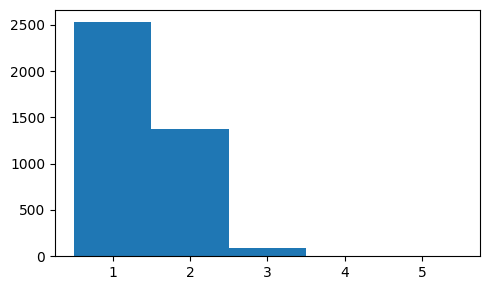

In [9]:
# plot histogram of total_positive
fig, ax = plt.subplots(figsize=(5, 3))
n, bins, patches = ax.hist(OPAL_counts['total_positive'], bins=[1,2,3,4,5,6], align='left')
fig.tight_layout()
plt.show()

In [10]:
# transform the data to count unique patterns
mean_intens_unit = mean_intens_thres_OPAL.copy()
mean_intens_unit = mean_intens_unit.loc[~(mean_intens_unit==0).all(axis=1)]
mean_intens_unit[mean_intens_unit > 0] = 1
mean_intens_unit

OPAL480  OPAL620  OPAL690  \
file                                       label                              
20460292_2A_13070-41475_component_data.tif 1          1.0      0.0      0.0   
                                           2          0.0      0.0      1.0   
                                           3          1.0      0.0      0.0   
                                           4          1.0      0.0      1.0   
                                           5          1.0      0.0      0.0   
...                                                   ...      ...      ...   
                                           5943       1.0      0.0      0.0   
                                           5946       0.0      0.0      0.0   
                                           5948       1.0      0.0      1.0   
                                           5949       0.0      0.0      0.0   
                                           5950       0.0      0.0      0.0   

                                                  OPAL780  OPAL570  
file                                       label                    
20460292_2A_13070-41475_component_data.tif 1          0.0      0.0  
                                           2          1.0      0.0  
                                           3          0.0      0.0  
                                           4          0.0      0.0  
                                           5          0.0      0.0  
...                                                   ...      ...  
                                           5943       0.0      0.0  
                                           5946       0.0      1.0  
                                           5948       0.0      0.0  
                                           5949       1.0      0.0  
                                           5950       0.0      1.0  

[4002 rows x 5 columns]

In [11]:
# show distribution of positive signals
mean_intens_unit.groupby(mean_intens_unit.columns.tolist(),as_index=False).size()

,OPAL480,OPAL620,OPAL690,OPAL780,OPAL570,size
0,0.0,0.0,0.0,0.0,1.0,510
1,0.0,0.0,0.0,1.0,0.0,211
2,0.0,0.0,0.0,1.0,1.0,38
3,0.0,0.0,1.0,0.0,0.0,660
4,0.0,0.0,1.0,0.0,1.0,76
5,0.0,0.0,1.0,1.0,0.0,100
6,0.0,0.0,1.0,1.0,1.0,9
7,0.0,1.0,0.0,0.0,0.0,417
8,0.0,1.0,0.0,0.0,1.0,116
9,0.0,1.0,0.0,1.0,0.0,12
